### Exploring Your Data
After you’ve identified the questions you’re trying to answer and have gotten your hands
on some data, you might be tempted to dive in and immediately start building models and
getting answers. But you should resist this urge. Your first step should be to explore your
data.

##### Exploring One-Dimensional Data
The simplest case is when you have a one-dimensional data set, which is just a collection
of numbers. For example, these could be the daily average number of minutes each user
spends on your site, the number of times each of a collection of data science tutorial
videos was watched, or the number of pages of each of the data science books in your data
science library.

An obvious first step is to compute a few summary statistics. You’d like to know how
many data points you have, the smallest, the largest, the mean, and the standard deviation.
But even these don’t necessarily give you a great understanding. A good next step is to
create a histogram, in which you group your data into discrete buckets and count how
many points fall into each bucket:

In [1]:
import math
def normal_cdf(x, mu=0,sigma=1):
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approximate inverse using binary search"""
    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    low_z, low_p = -10.0, 0 # normal_cdf(-10) is (very close to) 0
    hi_z, hi_p = 10.0, 1 # normal_cdf(10) is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2 # consider the midpoint
        mid_p = normal_cdf(mid_z) # and the cdf's value there
        if mid_p < p:
            # midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p
        else:
            break
    return mid_z
    """The function repeatedly bisects intervals until it narrows in on a Z that’s close enough to
        the desired probability."""

In [2]:
from collections import Counter
import matplotlib.pyplot as plt


def bucketize(point,bucket_size):
    """floor the point to next lower multiple of bucket size"""
    return bucket_size * math.floor(point/bucket_size)
def make_histogram(points , bucket_size):
    return Counter(bucketize(point,bucket_size) for point in points)

def plot_histogram(points , bucket_size , title=""):
    histogram = make_histogram(points,bucket_size)
    plt.bar(histogram.keys() , histogram.values() , width=bucket_size)
    plt.title(title)
    plt.show()

In [3]:
import random
random.seed(0)
# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]
# normal distribution with mean 0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random())
for _ in range(10000)]

Both have means close to 0 and standard deviations close to 58. However, they have very
different distributions.

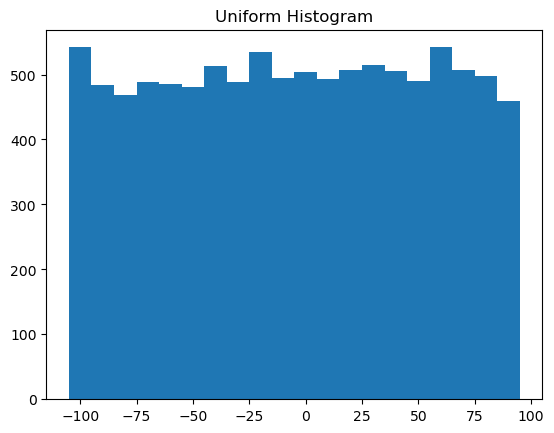

In [4]:
plot_histogram(uniform, 10, "Uniform Histogram")

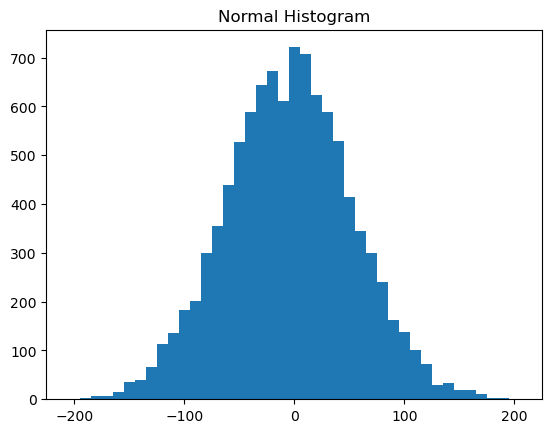

In [5]:
plot_histogram(normal, 10, "Normal Histogram")

In this case, both distributions had pretty different max and min, but even knowing that
wouldn’t have been sufficient to understand how they differed.

### Two Dimensions
Now imagine you have a data set with two dimensions. Maybe in addition to daily
minutes you have years of data science experience. Of course you’d want to understand
each dimension individually. But you probably also want to scatter the data.
For example, consider another fake data set:

In [6]:
def random_normal():
    '''returns a random draw from standard normal distribution'''
    return inverse_normal_cdf(random.random())

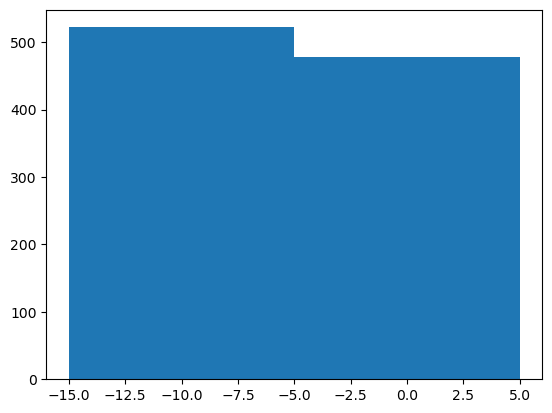

In [15]:
xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]

ys2 = [-x + random_normal() / 2 for x in xs]

plot_histogram(ys1,10)

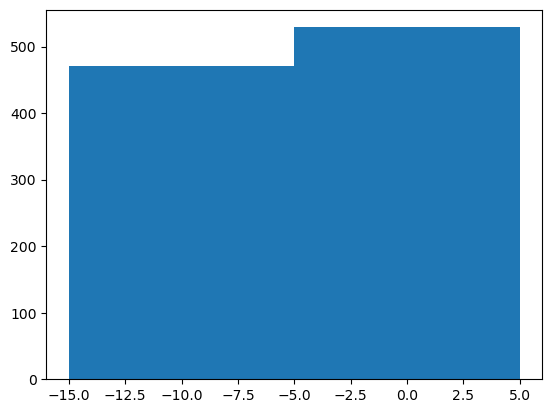

In [19]:
plot_histogram(ys2,10)

`both are normally distributed with the same mean and standard deviation`

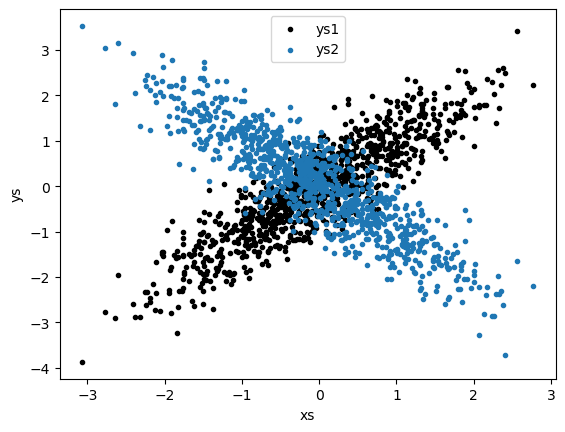

In [21]:
# but each has a very different joint distribution with xs 
plt.scatter(xs,ys1,marker="." ,color="black", label="ys1")
plt.scatter(xs,ys2,marker="." , label="ys2")
plt.xlabel("xs")
plt.ylabel("ys")
plt.legend(loc=9)
plt.show()

`the difference becomes more apparent if we compute the correlations for both which yield 0.9 and -0.9 respectively`

### Many Dimensions
With many dimensions, you’d like to know how all the dimensions relate to one another.
A simple approach is to look at the correlation matrix, in which the entry in row i and
column j is the correlation between the ith dimension and the jth dimension of the data:

In [53]:
from statistics import mean
from math import sqrt
def shape(m):
    return (len(m) , len(m[0])if m else 0)

def dot_prod(v,w):
    return sum(v_i*w_i for v_i ,w_i in zip(v,w))
def vector_sum_squared(v):
    return dot_prod(v,v)
def de_mean(x):
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]
def variance(x,flag='s'):
    '''here flag represents if the variance is to be calculated of a sample or a population the two options are p or s'''
    n = len(x)
    deviances = de_mean(x)
    return vector_sum_squared(deviances) / (n-1) if flag=='s' else n
def standard_deviation(x):
    return sqrt(variance(x))

def covariance(x,y):
    n = len(y)
    return dot_prod(de_mean(x),de_mean(y))//(n-1)
def correlation(x,y):
    std_x = standard_deviation(x)
    std_y = standard_deviation(y)
    
    if std_x > 0 and std_y > 0:
        return covariance(x,y) / std_x / std_y
    else:
        return 0
def get_row(m ,i):
    return m[i]
def get_col(m,i):
    return [m_i[i] for m_i in m]
def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix
    whose (i,j)th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j) # given i, create a list
            for j in range(num_cols)] # [entry_fn(i, 0), ... ]
            for i in range(num_rows)] # create one list for each i
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry
    is the correlation between columns i and j of data"""
    _, num_columns = shape(data)
    def matrix_entry(i, j):
        return round(correlation(get_col(data, i), get_col(data, j)),2)
    return make_matrix(num_columns, num_columns, matrix_entry)

In [56]:
import numpy as np
data = [np.random.rand(5).tolist() for _ in range(4)]

correlation_matrix(data)

[[0.0, -8.7, 0.0, -11.67, -7.78],
 [-8.7, 0.0, 0.0, -9.35, 0.0],
 [0.0, 0.0, 0.0, -8.34, -5.56],
 [-11.67, -9.35, -8.34, 0.0, 0.0],
 [-7.78, 0.0, -5.56, 0.0, 0.0]]

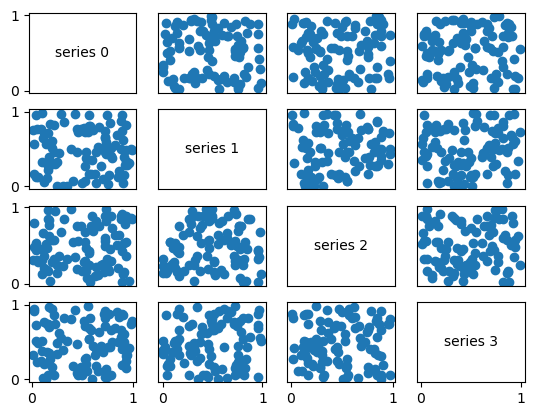

In [65]:
corr_data = [np.random.rand(100).tolist() for _ in range(4)]

# another approch would be to use a visual matrix 
num_vectors = len(corr_data)
fig, ax = plt.subplots(num_vectors, num_vectors)
for i in range(num_vectors):
    for j in range(num_vectors):
    # Scatter column_j on the x-axis vs. column_i on the y-axis
        if i != j: ax[i][j].scatter(corr_data[j], corr_data[i])
        # unless i == j, in which case show the series name
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
        xycoords='axes fraction',
        ha="center", va="center")
        # Then hide axis labels except left and bottom charts
        if i < num_vectors - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)
        # Fix the bottom-right and top-left axis labels, which are wrong because
        # their charts only have text in them
        ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
        ax[0][0].set_ylim(ax[0][1].get_ylim())
plt.show()